In [1]:
import numpy as np
import pandas as pd
import sys, os, glob, corner
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [4]:
# get rotation info
drot = pd.read_csv("../cks_frot/mazeh+15.tsv", delimiter="|", comment="#")
drot["kepid"] = drot.KIC
prots, vars, lphs = [], [], []
for i in range(len(drot)):
    try:
        prots.append(float(drot.Prot[i]))
    except:
        prots.append(np.nan)
    try:
        vars.append(float(drot.Rvar[i]))
    except:
        vars.append(np.nan)
    try:
        lphs.append(float(drot.LPH[i]))
    except:
        lphs.append(np.nan)
drot['Prot'] = prots
drot['Rvar'] = vars
drot['LPH'] = lphs

idxm15 = (drot.F==0)&(drot.G==0)&(drot['T']==0) # False positives, Giant, Temperature
idxm15 &= (drot.C==0) & (drot.kepid!=8043882)   # written after the ACF search but Rvar/Prot were not assigined
drotm15 = drot[idxm15].reset_index(drop=True)
drot['acf'] = (drot.M1==0)&(drot.M2==0)&(drot.R==0) # robust period
print ('ACF sample: %d'%len(drotm15))
print ('Prot assigned: %d'%np.sum(drotm15.Prot==drotm15.Prot))

ACF sample: 3072
Prot assigned: 3072


In [36]:
def clean(inputfile, postdir, dsigmaobs_th=2., feh_th=0.4, use_gyro=False):
    dinput = pd.read_csv(inputfile)
    dinput["kmag"] = dinput.kmag_corrected
    dinput["kmag_err"] = dinput.kmag_err_corrected
    dinput["parallax"] = dinput.parallax_corrected
    dinput["parallax_err"] = dinput.parallax_error_corrected
    dinput["teff_err"] = 110
    dinput["feh_err"] = 0.1
    dinput["logg_err"] = 0.1
    
    if not use_gyro:
        dpct = summarize_results(postdir, dinput, keys, obskeys)
    else:
        postdir_joint = postdir.replace("cks", "cksjoint")
        jidx = (dinput.acf==True) & (dinput.Prot==dinput.Prot)
        d_joint = dinput[jidx].reset_index(drop=True)
        d_iso = dinput[~jidx].reset_index(drop=True)
        dpct_j = summarize_results(postdir_joint, d_joint, keys, obskeys)
        dpct_i = summarize_results(postdir, d_iso, keys, obskeys)
        dpct = pd.concat([dpct_j, dpct_i]).reset_index(drop=True)
        
    fig = corner.corner(dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])
    
    idxgood = (dpct.dsigmaobs < dsigmaobs_th) & (np.abs(dpct.feh) < feh_th)
    dpct["idx"] = idxgood
    return dpct

def define_sample(inputfile, postdir, drot, m_min, m_max, use_gyro=False):
    dinput = pd.read_csv(inputfile)
    d = clean(inputfile, postdir, use_gyro=use_gyro)

    print ("# %d well-behaved stars out of %d."%(np.sum(d.idx), len(d)))
    sample_idx = d.idx & (m_min < d.iso_mass) & (d.iso_mass < m_max) 
    sample_idx_nobin = sample_idx & (~d.binflag)
    print ("# %d stars with median mass %.2f-%.2f Msun."%(np.sum(sample_idx), m_min, m_max))
    print ("# %d apparently single stars with median mass %.2f-%.2f Msun."%(np.sum(sample_idx_nobin), m_min, m_max))
    
    dsmp = d[sample_idx_nobin].reset_index(drop=True)
    fig = corner.corner(dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])    
    plt.suptitle("clean sample", fontsize=20)
    
    d = pd.merge(dsmp, drot[['kepid', 'acf', 'Prot', 'e_Prot', 'Rvar', 'LPH', 'w', 'D', 'N', 'C', 'G', 'T', 'F', 'R', 'M1', 'M2']])
    print ("# %d stars in the final sample."%len(d))
    return d

def get_posterior_samples(d, postdir, agekey="age", n_samples=10000, use_gyro=False):
    samples = []
    for i, kepid in enumerate(d.kepid):
        if not use_gyro:
            filename = postdir + "%s_samples.csv"%kepid
            dp = pd.read_csv(filename)[['feh', agekey]]
        else:
            filename = postdir.replace("cks", "cksjoint") + "%s_samples.csv"%kepid
            if os.path.exists(filename):
                dp = pd.read_csv(filename)[['feh', agekey]]
            else:
                filename = postdir + "%s_samples.csv"%kepid
                dp = pd.read_csv(filename)[['feh', agekey]]
        samples.append(np.array(dp)[:n_samples])
    samples = np.array(samples)
    return samples

In [37]:
obskeys = ['teff', 'feh', 'kmag', 'parallax']
keys = ['age', 'mass', 'radius'] + obskeys

In [54]:
m_min, m_max = 0.9, 1.0
#m_min, m_max = 1.0, 1.1
#m_min, m_max = 0.8, 0.9

In [55]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage/"
name = "iso_lina_m%.2f-%.2f"%(m_min, m_max)
agekey = "linage"
d = define_sample(inputfile, postdir, drot, m_min, m_max)
samples = get_posterior_samples(d, postdir, agekey='age')

KeyboardInterrupt: 

# 1093 well-behaved stars out of 1202.
# 246 stars with median mass 0.90-1.00 Msun.
# 231 apparently single stars with median mass 0.90-1.00 Msun.
# 204 stars in the final sample.


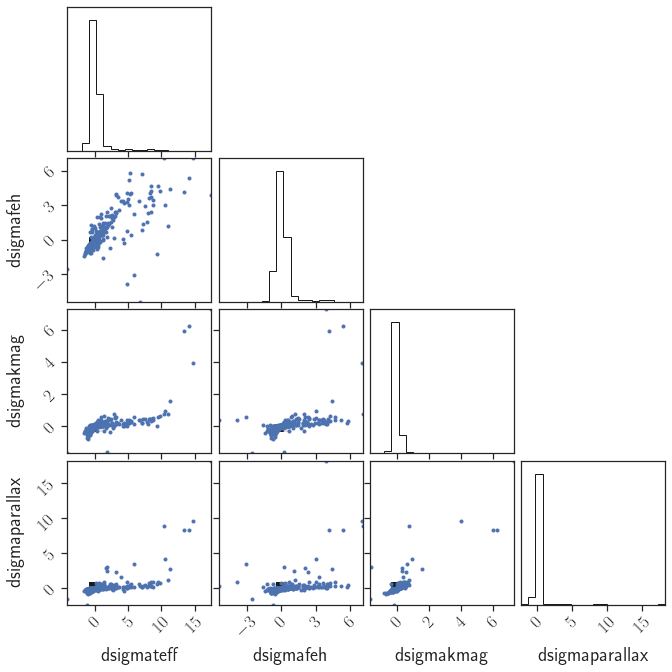

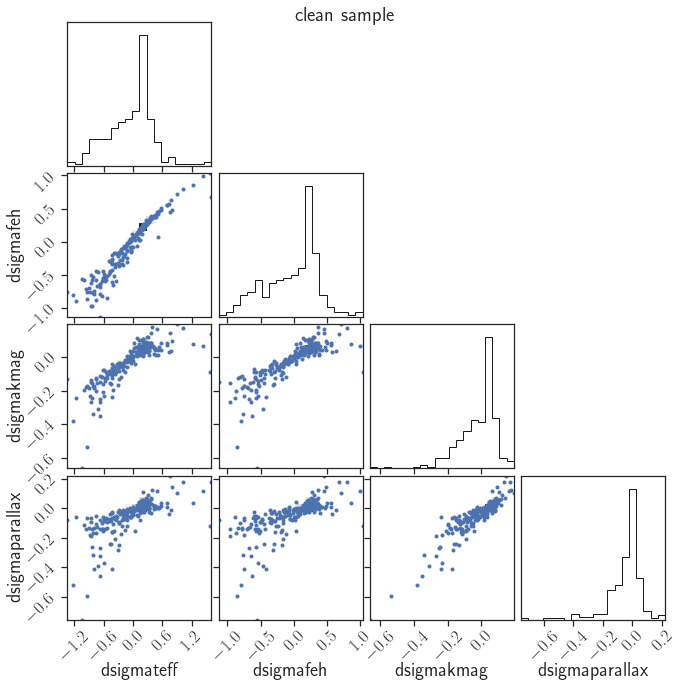

In [56]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage/"
name = "joint_lina_m%.2f-%.2f"%(m_min, m_max)
agekey = "linage"
d = define_sample(inputfile, postdir, drot, m_min, m_max, use_gyro=True)
samples = get_posterior_samples(d, postdir, agekey='age', use_gyro=True)

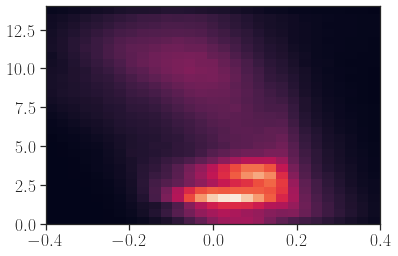

In [57]:
plt.hist2d(samples[:,:,0].ravel(), samples[:,:,1].ravel(), bins=[np.linspace(-0.4,0.4,30), np.linspace(0,14,30)]);

In [51]:
d.to_csv("%s.csv"%name, index=False)
np.savez("%s.npz"%name, samples=samples)

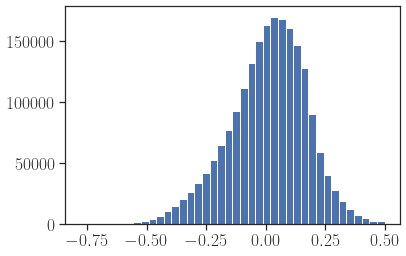

In [43]:
plt.hist(samples[:,:,0].ravel(), bins=40);

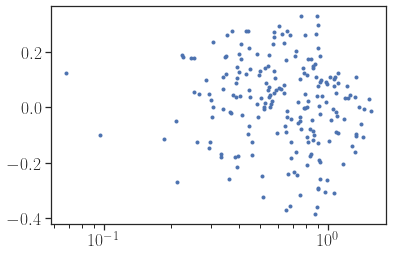

In [62]:
plt.xscale("log")
plt.plot(1./d.parallax, d.feh, '.')